In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

----
## INHOUD:

* [Data Acquisitie](#Data-Acquisitie)
* [AD Conversie](#AD-Conversie)
    * [Sampling](#Sampling)
    * [Quantization](#Quantization)
* [Statistische analyse van metingen (constante waarde)](#Statistische-analyse-van-metingen-met-een-constante-waarde)
* [Kalibreren van lineaire sensoren](#Kalibreren-van-lineaire-sensoren)
    
----    

## Data Acquisitie


Om analoge signalen op de pc verder te verwerken zijn enkele stappen nodig:


![Data Acquisitie Diagram](dataAcquisition.png)


We behandelen dus drie tussenstappen

>1. **Sensor**: Deze zet een fysische grootheid (bijvoorbeeld temperatuur) om in een elektrisch signaal. Dit wordt ook wel een transducer genoemd.
2. **Signaal conditionering**: Voordat het signaal de AD converter ingaat is het wenselijk om het daarom op voor te bereiden. Dat wil zeggen. Je moet er voor zorgen dat het signaal dusdanig versterkt of verzwakt wordt zodat het in het bereik van de AD converter past. Verder wordt er een anti-aliasing filter toegepast, waarvan het doel hieronder toegelicht wordt. 
3. **AD Conversie**: Dit is de werkelijke digitalisering stap, welk hieronder verder toelicht wordt.

------------
## AD Conversie

Een processor kan alleen wiskundige operaties uitvoeren op digitale signalen. Om een analoog signaal te digitaliseren zijn er twee acties nodig:
![Analog, discrete and digital signals](analog_discrete_digital.png)

---
### Sampling, Aliasing en Nyquist:

Sampling (of bemonsteren) is het periodiek bekijken en opnemen (punt voor punt) van het signaal. Dit gebeurt ongeveer instantaan (dus supersnel). Uiteindelijk wil je het originele signaal weer uit het digtale signaal terug krijgen, ook wel reconstructie genoemd. Nu blijkt dat het samplen gevolgen voor de reconstructie kan hebben.

Stel je voor we gaan twee sinusvormige ingangssignalen met een zekere frequentie van respectievelijk $f_1= 0.3~Hz$ en $f_2= 1.3~Hz$ samplen met een sample frequentie van $f_s = 1~Hz$. Wanneer je naar de digitale representatie kijken (dus puur de punten) dan blijkt dat er ook een sinus met een hoger frequentie in zou inpassen. Het blijkt dat deze signaal frequentie dan hoger dan de halve samplfrequentie moet zijn. Hieruit kan je concluderen dat wanneer je ten alle tijde je originele signaal wilt kunnen reconstrueren je moet voldoen aan:

$$f_s \geq 2 f_{max}$$

#### In andere woorden: Zorg dat je sample frequentie minimaal 2x zo groot is dan de hoogste frequentie die je wilt gaan meten!

Zie het onderstaande voorbeeld voor het sampling effect:

<IPython.core.display.Javascript object>


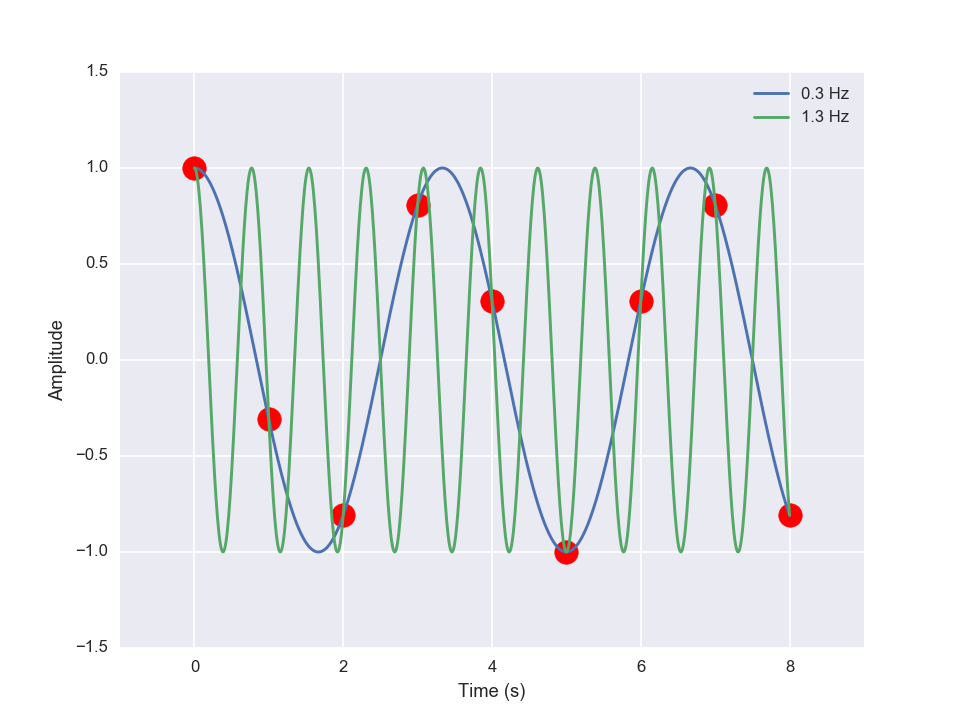

In [3]:
T = 1 #sampling period
t = np.linspace(0,8,801) #for the continuous time signals
n = np.arange(0,9) #discrete time intervals

f1 = 0.3
f2 = 1.3

w1 = 2*np.pi*f1
w2 = 2*np.pi*f2

y1 = np.cos(w1*t)
y2 = np.cos(w2*t)


plt.figure(num=None, figsize=(8,6), dpi=120, facecolor='w', edgecolor='k')
plt.plot(t,y1, label='0.3 Hz')
plt.plot(t,y2, label='1.3 Hz')
plt.scatter(n,np.cos(w1*n*T),marker='o',color='red',s=200) #digitaal 0.3Hz signaal
#plt.scatter(n,np.cos(w2*n*T),marker='.',color='blue',s=200) #digitaal 1.3Hz signaal
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')

-----

## Quantization

Het samplen zorgt voor een opdeling in de tijd. Kwantiseren is nodig om het signaal op te delen in de amplitude. Het aantal niveaus (levels) wordt bepaald door het aantal bits van de AD converter. 

Stel we hebben een 3 bits analoog naar digitaal (AD) converter, het aantal levels wat we dan verkrijgen is:

\begin{equation}
levels = 2^{n} = 2^3 = 8
\end{equation}

De resolutie (vaak in Volt uitgedrukt) wordt bepaald door de verhouding in het bereik van de AD converter en het aantal levels:

\begin{equation}
resolutie = \frac{bereik}{levels} = \frac{1 - - 1}{8} = 0.25~V
\end{equation}

<IPython.core.display.Javascript object>


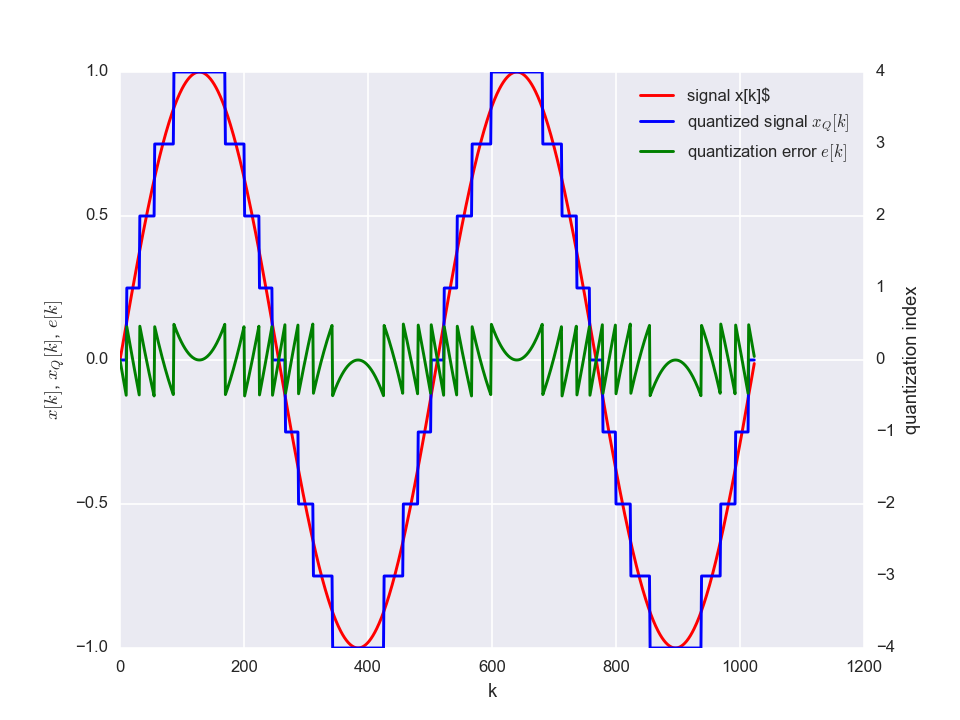

In [4]:
N = 2**10  # length of signal

# generate signal
x = np.sin(4*np.pi/N * np.arange(N))
#x = 1*np.random.randn(N)
# quantize signal
xi = np.round(4 * x)
xQ = 1/4* xi
e = xQ - x

# plot (quantized) signals
fig, ax1 = plt.subplots(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
ax2 = ax1.twinx()

ax1.plot(x, 'r', label=r'signal x[k]$')
ax1.plot(xQ, 'b', label=r'quantized signal $x_Q[k]$')
ax1.plot(e, 'g', label=r'quantization error $e[k]$')
ax1.set_xlabel('k')
ax1.set_ylabel(r'$x[k]$, $x_Q[k]$, $e[k]$')
ax1.legend()

ax2.set_ylim([-4, 4])
ax2.set_ylabel('quantization index')
ax2.grid()
plt.show()

<IPython.core.display.Javascript object>


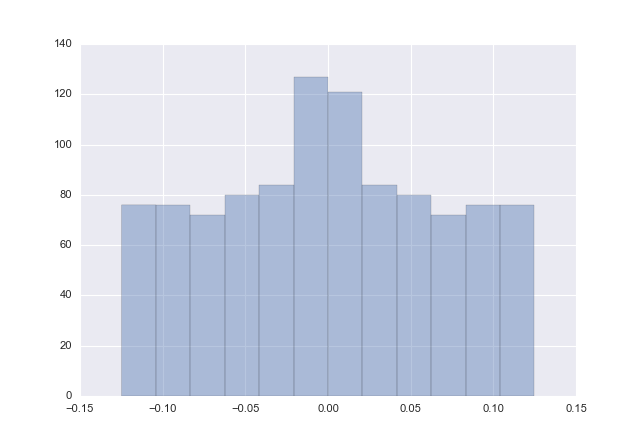

In [5]:
plt.figure()
sns.distplot(e,kde=False)
plt.show()

## Signal-to-Noise Ratio (SNR)

De kwaliteit van het kwantiseren kan je uitdrukken door middel van de [signal-to-noise ratio](https://en.wikipedia.org/wiki/Signal-to-noise_ratio) (SNR):

$$ SNR~[dB] = 10 \cdot \log_{10} \left( \frac{\sigma_x^2}{\sigma_e^2} \right)$$

waar $\sigma_x^2$ and $\sigma_e^2$ de varianties van het signaal en ruis inhouden. 

Zonder de berekening te geven kan je er van uit gaan dat de SNR bepaald wordt door:
$$ SNR~[dB] \approx 6.02 \, n + 1.76$$
Waarbij $n$ het aantal bits van de AD converter is. 

---

---

# Statistische analyse van metingen met een constante waarde

We kunnen een meting als volgt modelleren. Het geen wat we meten $y_{meting}$ bestaat uit de werkelijke waarde $y_{true}$ een systematische fout, ook wel bias genoemd, $e_{bias}$ en een toevallige (random) fout $e_{random}$. Deze toevallige fout is, zoals de naam al aangeeft, telkens anders wat betekend dat ze onafhankelijk van elkaar zijn.

\begin{equation}
y_{meting} = y_{true} + e_{bias} + e_{random}
\end{equation}

**Voorbeeld:**

Stel onze set metingen bestaan uit een gps posities (gemakshalve zijn enkel x en y waarden genomen (dus 2D ipv 3D), waarbij gemeten werd op 1 en hetzelfde punt. De werkelijke waarde ($y_{true}$) is dus ten alle tijde hetzelfde (in het rood). 

We kunnen de gemeten X posities uitzetten tegen de gemeten Y posities (in het blauw) en vervolgens de verdeling (distributie) bekijken.

In [6]:
def createMeasurementPicture(numpoints=100,mean=(0,0),std=(3,3)):
    meting = std*np.random.randn(numpoints,2)+mean
    g = sns.jointplot(meting[:,0],meting[:,1],size=10)
    g.set_axis_labels('X-Positie (m)', 'Y-Positie (m)')
    g.ax_joint.plot(0,0,'ro',markersize=20)
    g.ax_joint.axis([-4,4,-4,4])
    plt.show()
    return meting

<IPython.core.display.Javascript object>


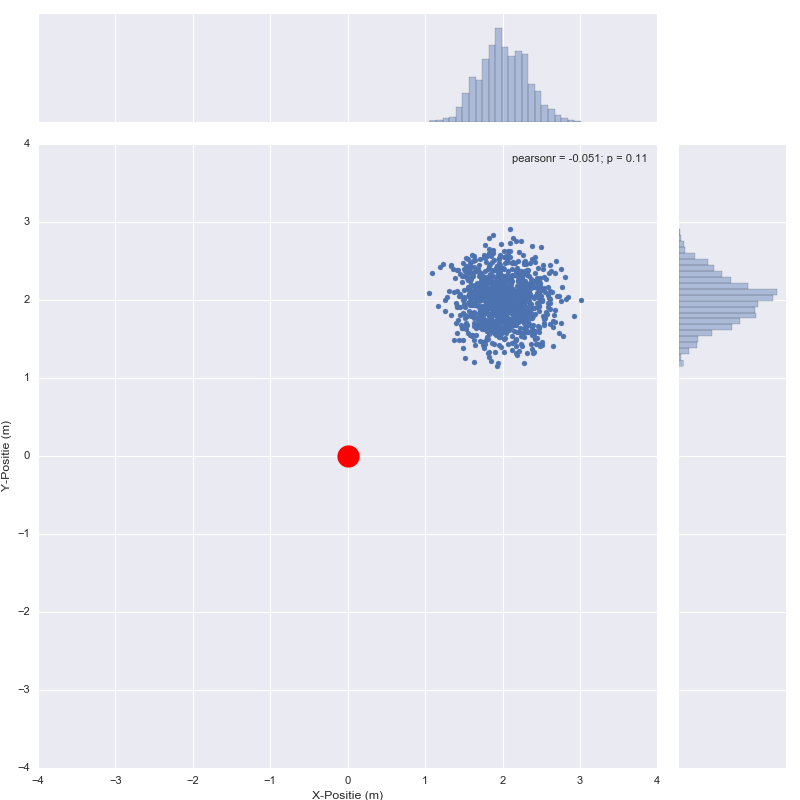

In [7]:
 meting = createMeasurementPicture(numpoints=1000,mean=(2,2),std=(.3,.3))

Je merkt dat er een zekere spreiding van punten is, waarbij het gemiddelde middelpunt niet overeenkomt met het werkelijke middelpunt. 

> **Bias / systematische fouten** kunnen bijvoorbeeld worden veroorzaak door:
    - onderliggende kaart is verkeerde gepositioneerd
    - er is een klok offset in 1 van de GPS satellieten
    - weersconditions
    
> **Toevallige / random fouten** kunnen bijvoorbeeld worden veroorzaak door:
    - Ruis in de gps ontvangst sensor
    - Afleesfouten
   
Indien je de metingen ($x$) als normaal verdeeld kan beschouwen (dit kan je aantonen door heel veel metingen te gaan doen en dan een histogram opstellen) kun je het gemiddelde ($\bar{x}$) en de spreiding (standaard deviatie $\sigma_{x}$ of variantie $\sigma^2_{x}$) als volgt berekenen:

\begin{equation}
\bar{x} = \frac{1}{N} \sum^{N}_{i=1} x_i
\end{equation}


\begin{equation}
\sigma_x^2 = \frac{1}{N} \sum^{N}_{i=1} \left(x_i - \bar{x} \right)^2
\end{equation}


Uiteraard kan je in veel pakketten ook 1 commando gebruiken om deze waarden uit te rekenen:

In [8]:
print('Het gemiddelden (X en Y): {} m'.format(np.mean(meting,axis=0)))
print('De varianties (X en Y): {} m'.format(np.var(meting,axis=0)))
print('De standaard deviaties (X en Y): {} m'.format(np.std(meting,axis=0)))

Het gemiddelden (X en Y): [ 2.01161601  1.9876171 ] m
De varianties (X en Y): [ 0.09435304  0.08840775] m
De standaard deviaties (X en Y): [ 0.3071694  0.2973344] m


## Niet normaal verdeelde meting:

Vaak kun je veronderstelling dat het doen van metingen normaal verdeeld zijn. **Ga hier echter niet zo maar vanuit.** Bijvoorbeeld een dobbelsteen 100 keer werpen geeft de volgende (uniforme) verdeling:

<IPython.core.display.Javascript object>


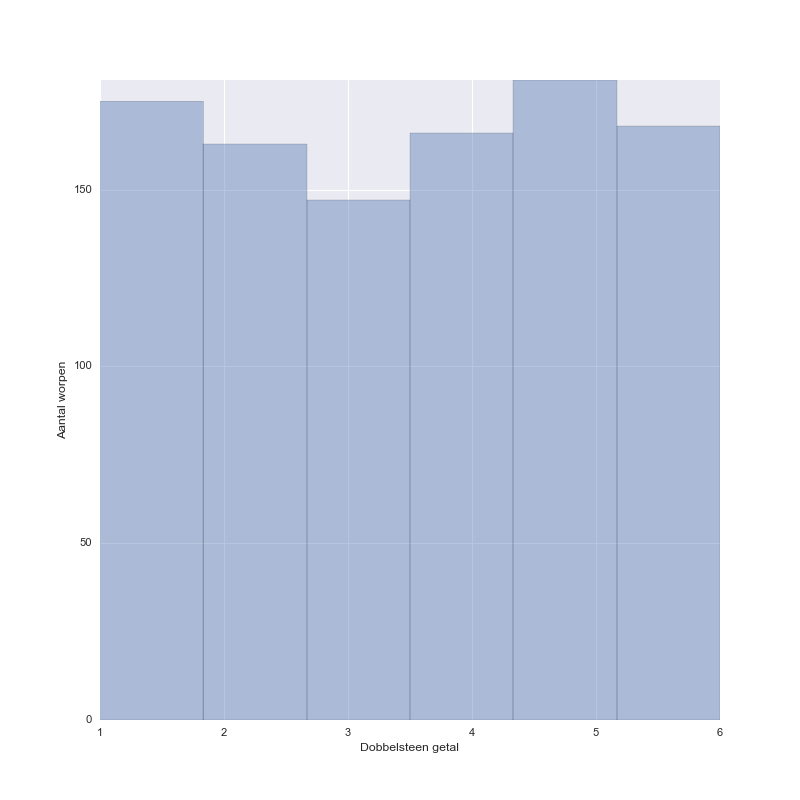

In [9]:
N=1000
roll = np.random.randint(1,7,N)
plt.figure(num=None, figsize=(10, 10))#, dpi=120, facecolor='w', edgecolor='k')
sns.distplot(roll,kde=False,bins=6)
#plt.xticks(np.arange(1,7))
plt.xlabel('Dobbelsteen getal')
plt.ylabel('Aantal worpen')
plt.axis('tight')
plt.show()

-----

# Kalibreren van lineaire sensoren


Stel een meting kan als volgt beschreven worden:

\begin{equation}
y_{meas} = a \cdot y_{true} + b + e
\end{equation}

Om $y_{true}$ te vinden moeten we gaan **kalibreren**. Wezenlijk houdt dit in dat we de waarde van $a$ (versterkingsfactor, ofwel 'gain') en de offset $b$ moeten gaan bepalen. De toevallige fout $e$ kunnen we niet weg kalibreren dus die laten we buiten beschouwing. We kunnen de formule als volgt omzetten:

\begin{equation}
y_{true} = a^{-1} \cdot (y_{meas} - b)
\end{equation}

We moeten dus wederom het 'echte' proces weten. Bij het kalibreren ga je dus je metingen altijd vergelijking met de werkelijke waarden. Via de lineaire kleinste kwadraten methode (linear least squares) kunnen we $a$ en $b$ bepalen aan de hand van een set metingen.


Stel we hebben een set metingen gedaan met een (lineaire) temperatuurs gevoelige sensor, die we willen kalibreren zodat we de werkelijke temperatuur (blauw) vinden. Op de *X-As* staat de ingestelde temperatuur (bijvoorbeeld van een oven). Op de *Y-As* staat de gemeten temperatuur (groen) en de werkelijke temperatuur (blauw).

<IPython.core.display.Javascript object>


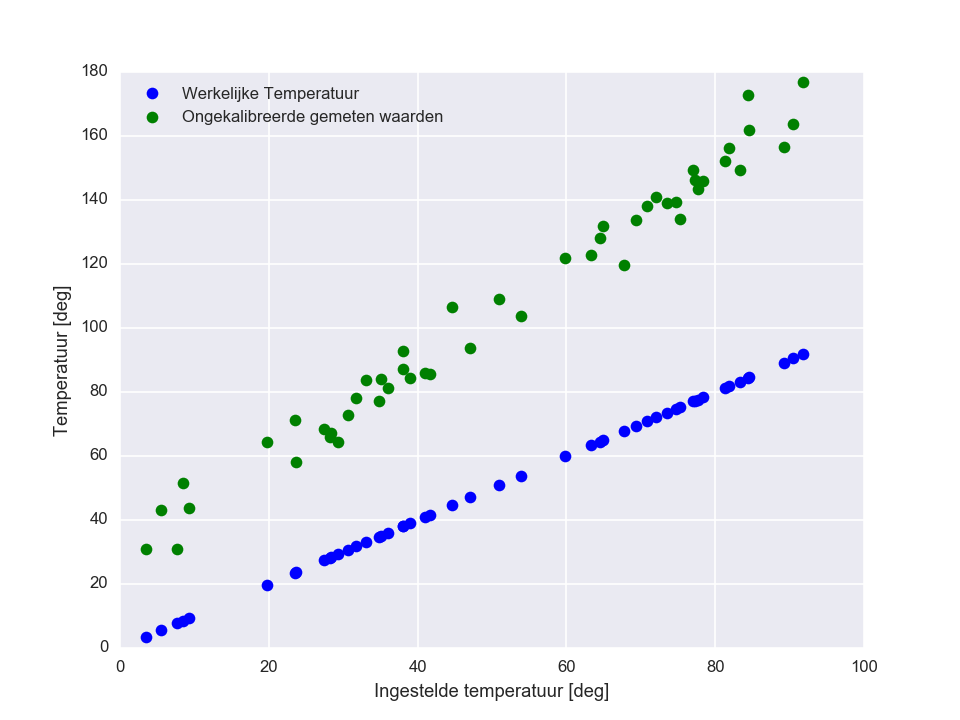

In [10]:
def generateTempData(a=1.5,b=30,Nmeas=100,variance=5e0):
    xtrue = 100*np.random.rand(Nmeas,1)
    ytrue = xtrue
    ymeas = np.zeros((Nmeas,1))
    
    for i in range(Nmeas):
        ymeas[i] = a*ytrue[i] + b + variance*np.random.randn(1)
    return xtrue,ytrue,ymeas

Nmetingen = 50
plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k');
xtrue,ytrue,ymeas = generateTempData(Nmeas=Nmetingen)
plt.plot(xtrue,ytrue,'bo',label='Werkelijke Temperatuur')
plt.plot(xtrue,ymeas,'go',label='Ongekalibreerde gemeten waarden')
plt.xlabel('Ingestelde temperatuur [deg]')
plt.ylabel('Temperatuur [deg]')
plt.legend(loc='upper left')
plt.show()

We zoeken de coefficienten a en b, deze bepalen de (optimale, dus rekening houdend met de ruis) offset en stijlheid (versterking) van bovenstaande groene plot. Wanneer deze bekend zijn kunnen we gaan compenseren (en is de sensor gekalibreerd) en vinden we de werkelijke meting (blauw). 

Zoals eerder verteld kunnen we de meting schrijven als:

$$y_{meas} = a \cdot y_{true} + b$$ 

Dit kunnen we verder omschrijven als:

$$y_{meas} = M p$$ 

waarbij:

$$M =\left[y_{true} \hspace{0.2cm} 1\right]$$
en:
$$p = [a \hspace{0.2cm} b]^T$$. 

Let op dat de $1$ in $M$ een een vector is met dezelfde lengte als $y_{true}$. 
De *vector* $p$ bevat de waarden voor $a$ en $b$ waarin we geintereeseerd zijn.
Om deze $p$ te bepalen schrijven we:

$$p = M^{-1} \cdot y_{meas}$$

Doordat er doorgaans meer meetpunten zijn dan de te bepalen parameters kunnen we de least squares functionaliteit gebruiken (specifiek: M is niet vierkant dus niet zomaar te inverteren) van een willekeurig software pakket. Bijvoorbeeld in MatLAB is dit het commando:

```octave
p = M\y_meas
```

We krijgen dus een vector p terug waarvan het 1e getal de gain (A) is en het tweede getal de offset (b). Deze vullen we in de eerder opgestelde formule in om de werkelijke waarde van het proces zo goed mogelijk te bepalen:

\begin{equation}
y_{true} = a^{-1} \cdot (y_{meas} - b)
\end{equation}

Versterkingsfactor: 1.5278165352093995, offset: 27.890272284153763


<IPython.core.display.Javascript object>


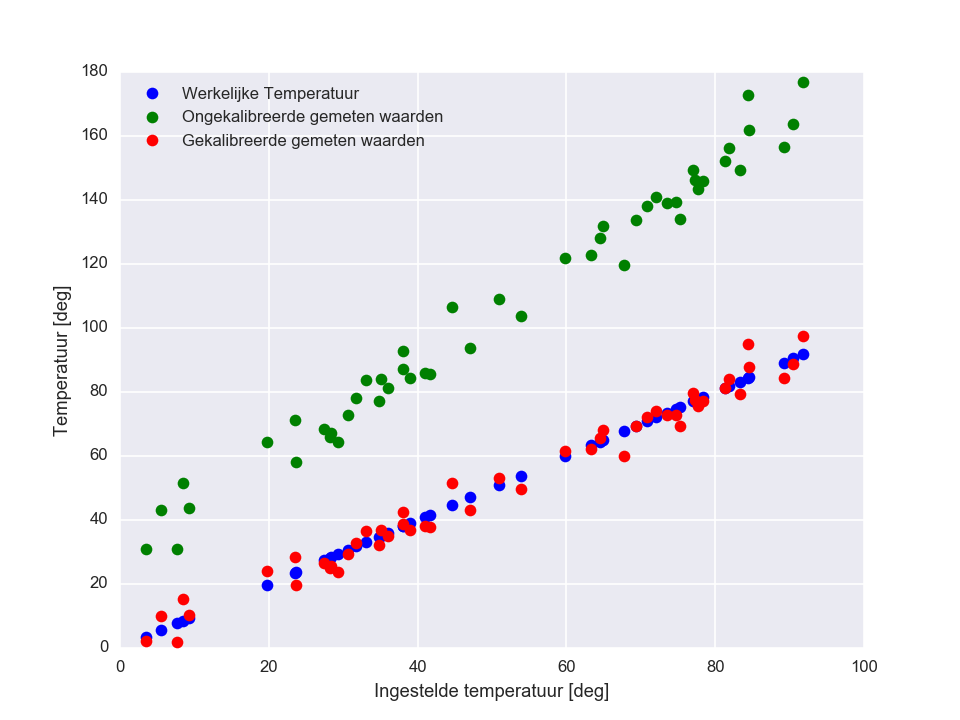

In [11]:
M = np.hstack([ytrue, np.ones((Nmetingen,1))])
A,b = np.linalg.lstsq(M, ymeas)[0]

print('Versterkingsfactor: {}, offset: {}'.format(A[0],b[0]))

plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k');
plt.plot(xtrue,ytrue,'bo',label='Werkelijke Temperatuur')
plt.plot(xtrue,ymeas,'go',label='Ongekalibreerde gemeten waarden')
plt.plot(xtrue,A**(-1)*(ymeas-b),'ro',label='Gekalibreerde gemeten waarden')
plt.xlabel('Ingestelde temperatuur [deg]')
plt.ylabel('Temperatuur [deg]')
plt.legend(loc='upper left')
plt.show()

> Bedenk zelf hoe je vervolgens de standaard deviatie van $e$ kunt bepalen.